In [ ]:
!pip install fbprophet

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import pandas as pd
import plotly.express as px

mpl.rcParams['figure.figsize']=(10,8)
mpl.rcParams['axes.grid'] = False

In [ ]:
df = pd.read_csv('http://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv')

In [ ]:
df

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820
...,...,...
10315,2015-01-31 21:30:00,24670
10316,2015-01-31 22:00:00,25721
10317,2015-01-31 22:30:00,27309
10318,2015-01-31 23:00:00,26591


In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  10320 non-null  datetime64[ns]
 1   value      10320 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 161.4 KB


In [ ]:
df.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [ ]:
df = df.set_index('timestamp').resample("H").mean()

In [ ]:
df

,value
timestamp,
2014-07-01 00:00:00,9485.5
2014-07-01 01:00:00,5433.0
2014-07-01 02:00:00,3346.5
2014-07-01 03:00:00,2216.5
2014-07-01 04:00:00,2189.5
...,...
2015-01-31 19:00:00,28288.5
2015-01-31 20:00:00,24138.0
2015-01-31 21:00:00,24194.5


In [ ]:
fig = px.line(df.reset_index(),x='timestamp',y='value',title='NYC Taxi Demand')
fig.update_xaxes(
    rangeselector =dict(
         buttons=list([
              dict(count=1,label="1y",step="year",stepmode="backward"),
              dict(count=2,label="2y",step="year",stepmode="backward"),
              dict(count=3,label="3y",step="year",stepmode="backward"),
              dict(step="all")                  

         ])
          )
)
fig.show()

In [ ]:
from fbprophet import Prophet

In [ ]:
taxi_df = df.reset_index()[['timestamp','value']].rename({'timestamp':'ds','value':'y'},axis='columns')

In [ ]:
taxi_df

,ds,y
0,2014-07-01 00:00:00,9485.5
1,2014-07-01 01:00:00,5433.0
2,2014-07-01 02:00:00,3346.5
3,2014-07-01 03:00:00,2216.5
4,2014-07-01 04:00:00,2189.5
...,...,...
5155,2015-01-31 19:00:00,28288.5
5156,2015-01-31 20:00:00,24138.0
5157,2015-01-31 21:00:00,24194.5
5158,2015-01-31 22:00:00,26515.0


In [ ]:
train = taxi_df[(taxi_df['ds']>='2014-07-01') & (taxi_df['ds']<='2015-01-27')]
test = taxi_df[(taxi_df['ds']>'2015-01-27')]

In [ ]:
train.shape

(5041, 2)

In [ ]:
test.shape

(119, 2)

In [ ]:
test

,ds,y
5041,2015-01-27 01:00:00,39.5
5042,2015-01-27 02:00:00,29.0
5043,2015-01-27 03:00:00,9.5
5044,2015-01-27 04:00:00,14.5
5045,2015-01-27 05:00:00,29.0
...,...,...
5155,2015-01-31 19:00:00,28288.5
5156,2015-01-31 20:00:00,24138.0
5157,2015-01-31 21:00:00,24194.5
5158,2015-01-31 22:00:00,26515.0


In [ ]:
m = Prophet(changepoint_range=0.95)

In [ ]:
m.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
future = m.make_future_dataframe(periods=119,freq='H')
future.tail(167)

,ds
4993,2015-01-25 01:00:00
4994,2015-01-25 02:00:00
4995,2015-01-25 03:00:00
4996,2015-01-25 04:00:00
4997,2015-01-25 05:00:00
...,...
5155,2015-01-31 19:00:00
5156,2015-01-31 20:00:00
5157,2015-01-31 21:00:00
5158,2015-01-31 22:00:00


In [ ]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower']].tail()

,ds,yhat,yhat_lower
5155,2015-01-31 19:00:00,23778.529213,18745.360102
5156,2015-01-31 20:00:00,24342.584334,19351.195116
5157,2015-01-31 21:00:00,23219.297735,18312.556098
5158,2015-01-31 22:00:00,21027.355314,16085.735180
5159,2015-01-31 23:00:00,18500.216845,13706.506591


In [ ]:
results=pd.concat([taxi_df.set_index('ds')['y'],forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']]],axis=1)

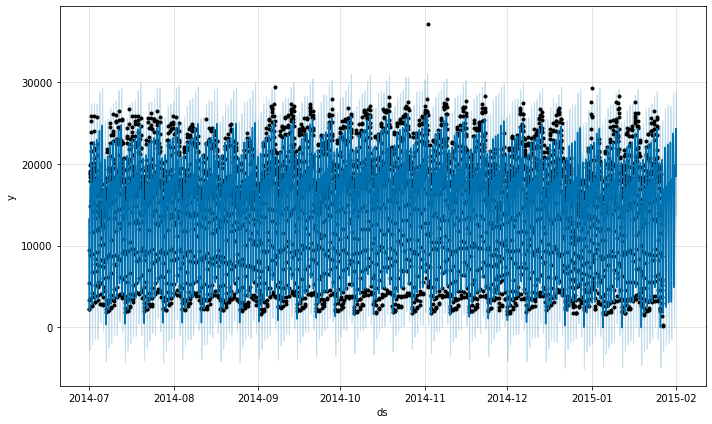

In [ ]:
fig1 = m.plot(forecast)

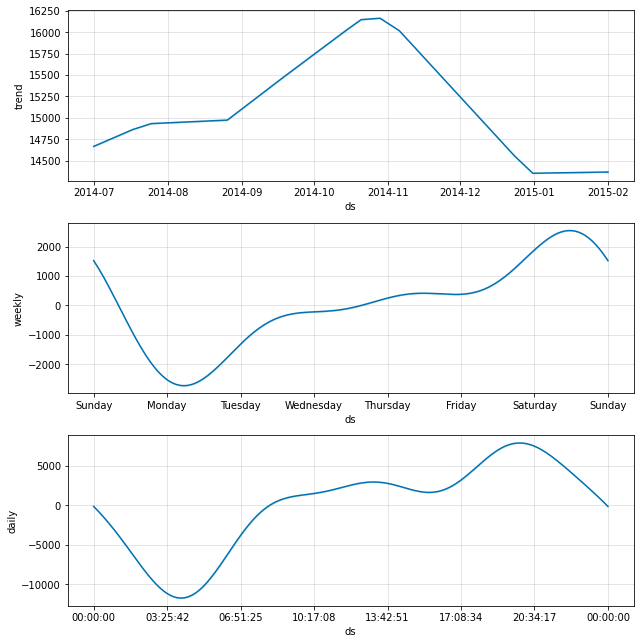

In [ ]:
comp=m.plot_components(forecast)

In [ ]:
results

,y,yhat,yhat_lower,yhat_upper
ds,,,,
2014-07-01 00:00:00,9485.5,13240.732792,8537.327767,18232.637090
2014-07-01 01:00:00,5433.0,10232.486172,5409.612039,14964.942125
2014-07-01 02:00:00,3346.5,6669.099458,1870.965882,11344.364895
2014-07-01 03:00:00,2216.5,3448.054270,-824.859601,8299.045864
2014-07-01 04:00:00,2189.5,2017.409931,-2801.320443,6651.397288
...,...,...,...,...
2015-01-31 19:00:00,28288.5,23778.529213,18745.360102,28534.945964
2015-01-31 20:00:00,24138.0,24342.584334,19351.195116,28976.280062
2015-01-31 21:00:00,24194.5,23219.297735,18312.556098,28001.087727


In [ ]:
results['error'] = results['y']-results['yhat']

In [ ]:
results['uncertainty'] = results['yhat_upper']-results['yhat_lower']

In [ ]:
results

,y,yhat,yhat_lower,yhat_upper,error,uncertainty
ds,,,,,,
2014-07-01 00:00:00,9485.5,13240.732792,8537.327767,18232.637090,-3755.232792,9695.309323
2014-07-01 01:00:00,5433.0,10232.486172,5409.612039,14964.942125,-4799.486172,9555.330086
2014-07-01 02:00:00,3346.5,6669.099458,1870.965882,11344.364895,-3322.599458,9473.399013
2014-07-01 03:00:00,2216.5,3448.054270,-824.859601,8299.045864,-1231.554270,9123.905465
2014-07-01 04:00:00,2189.5,2017.409931,-2801.320443,6651.397288,172.090069,9452.717731
...,...,...,...,...,...,...
2015-01-31 19:00:00,28288.5,23778.529213,18745.360102,28534.945964,4509.970787,9789.585861
2015-01-31 20:00:00,24138.0,24342.584334,19351.195116,28976.280062,-204.584334,9625.084945
2015-01-31 21:00:00,24194.5,23219.297735,18312.556098,28001.087727,975.202265,9688.531629


In [ ]:
results[results['error'].abs()>1.5*results['uncertainty']]

,y,yhat,yhat_lower,yhat_upper,error,uncertainty
ds,,,,,,
2014-11-02 01:00:00,37204.5,14218.892870,9404.537682,19035.532374,22985.607130,9630.994691
2015-01-01 01:00:00,29292.0,11405.545567,6670.810845,16233.348560,17886.454433,9562.537715
2015-01-01 02:00:00,25753.5,7770.054639,3286.732273,12727.368174,17983.445361,9440.635901
2015-01-01 03:00:00,22067.0,4478.895177,-428.136038,9142.365175,17588.104823,9570.501214
2015-01-26 19:00:00,4565.5,19771.308307,14755.159111,24486.867256,-15205.808307,9731.708146
2015-01-26 20:00:00,3630.5,20546.581743,16011.312186,25369.359844,-16916.081743,9358.047658
2015-01-26 21:00:00,2907.0,19647.710004,14820.266092,24276.977725,-16740.710004,9456.711632
2015-01-26 22:00:00,1324.5,17691.969234,12670.261533,22485.515267,-16367.469234,9815.253735
2015-01-26 23:00:00,243.0,15411.348672,10422.439114,20127.713405,-15168.348672,9705.274290


In [ ]:
results['anomaly'] = results.apply(lambda x:'Yes' if (np.abs(x['error'])>1.5*x['uncertainty']) else 'No',axis=1)

In [ ]:
results

,y,yhat,yhat_lower,yhat_upper,error,uncertainty,anomaly
ds,,,,,,,
2014-07-01 00:00:00,9485.5,13240.732792,8537.327767,18232.637090,-3755.232792,9695.309323,No
2014-07-01 01:00:00,5433.0,10232.486172,5409.612039,14964.942125,-4799.486172,9555.330086,No
2014-07-01 02:00:00,3346.5,6669.099458,1870.965882,11344.364895,-3322.599458,9473.399013,No
2014-07-01 03:00:00,2216.5,3448.054270,-824.859601,8299.045864,-1231.554270,9123.905465,No
2014-07-01 04:00:00,2189.5,2017.409931,-2801.320443,6651.397288,172.090069,9452.717731,No
...,...,...,...,...,...,...,...
2015-01-31 19:00:00,28288.5,23778.529213,18745.360102,28534.945964,4509.970787,9789.585861,No
2015-01-31 20:00:00,24138.0,24342.584334,19351.195116,28976.280062,-204.584334,9625.084945,No
2015-01-31 21:00:00,24194.5,23219.297735,18312.556098,28001.087727,975.202265,9688.531629,No


In [ ]:
fig = px.scatter(results.reset_index(),x='ds',y='y',color='anomaly',title='NYC Taxi Demand')


In [ ]:
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector =dict(
         buttons=list([
              dict(count=1,label="1y",step="year",stepmode="backward"),
              dict(count=2,label="2y",step="year",stepmode="backward"),
              dict(count=3,label="3y",step="year",stepmode="backward"),
              dict(step="all")                  

         ])
          )
)
fig.show()